# Categorisez automatiquement des questions - Modelisation

In [1]:
%%script echo skipping
from google.colab import drive
drive.mount('/content/drive')

skipping


# SOMMAIRE
* [PREPARATION](#PREPARATION)
* [CHARGEMENT](#CHARGEMENT)
* [MODELISATION](#Modelisation)
    * [Bayes naïf](#Bayes-naïf)
    * [Random forest](#Random-forest)
    * [XGBoost](#XGBoost)
    * [Reseau de neurones](#Reseau-de-neurones)
    * [LDA](#LDA)

# PREPARATION

## import des librairies

In [2]:
import joblib
import pandas as pd
import matplotlib as mplt
import matplotlib.pyplot as plt
from matplotlib import cm #colormap
import numpy as np

import seaborn as sns
import re

from sklearn.decomposition import LatentDirichletAllocation

from sklearn.model_selection import train_test_split
from sklearn import naive_bayes
from sklearn.metrics import adjusted_rand_score, accuracy_score
from sklearn.ensemble import RandomForestClassifier

from sklearn import linear_model

from xgboost import XGBClassifier

import tensorflow as tf

## Paramétrage du notebook

In [3]:
from matplotlib import font_manager

font_dirs = ['/Library/Fonts/']
font_files = font_manager.findSystemFonts(fontpaths=font_dirs)

for font_file in font_files:
    font_manager.fontManager.addfont(font_file)

# set font
plt.rcParams['font.family'] = 'Comic Sans'
plt.rcParams['font.sans-serif'] = 'Franklin Gothic Book'

In [4]:
sns.set(rc={
 'axes.axisbelow': False,
 'axes.edgecolor': 'lightgrey',
 'axes.facecolor': 'None',
 'axes.grid': False,
 'axes.labelcolor': 'dimgrey',
 'axes.spines.right': False,
 'axes.spines.top': False,
 'figure.facecolor': 'white',
 'lines.solid_capstyle': 'round',
 'patch.edgecolor': 'w',
 'patch.force_edgecolor': True,
 'text.color': 'dimgrey',
 'xtick.bottom': False,
 'xtick.color': 'dimgrey',
 'xtick.direction': 'out',
 'xtick.top': False,
 'ytick.color': 'dimgrey',
 'ytick.direction': 'out',
 'ytick.left': False,
 'ytick.right': False})

#mplt.font_manager._rebuild()
#mplt.font_manager.findfont('Franklin Gothic Book',rebuild_if_missing=True)


pd.options.display.max_colwidth=200
pd.options.display.min_rows=30
pd.options.display.max_columns=50

## Declaration des fonctions

In [5]:
def confusionMatrixAcc(y_true, y_pred):
    """
    Fonction qui retourne la matrice de confusion

    Parameters
    ----------
    y_true : pandas Series
        une Serie de valeurs (labels) reelles
    y_pred : pandas Series
        une Serie de valeurs (labels) predites
    Returns
    -------
    confusionMatrix : DataFrame
        la matrice de confusion
    """

    dfConfusion=pd.crosstab(y_test, y_pred_test,rownames=['Reel'], colnames=['Predit'], margins=False)
    confusionMatrix=pd.DataFrame()

    for c in dfConfusion.columns:
        try:
            TP=dfConfusion.loc[c,c]
            FP=dfConfusion.loc[:,c].sum()-dfConfusion.loc[c,c]
            TN=np.diagonal(dfConfusion).sum()-dfConfusion.loc[c,c]
            FN=dfConfusion.loc[c,:].sum()-dfConfusion.loc[c,c]
            TPR=TP/(TP+FN) # taux de vrai positif
            FPR=FP/(FP+TN) # taux de faux positifs
            Accuracy=(TP+TN)/(TP+FP+TN+FN)
        except:
            TP=0
            FP=0
            TN=0
            FN=0
            TPR=0
            FPR=0
            Accuracy=0
        confusionMatrix=pd.concat([confusionMatrix,
        pd.DataFrame({
            'Class':c,
            'TP':[TP],
            'FP':[FP],
            'TN':[TN],
            'FN':[FN],
            'TPR':[TPR],
            'FPR':[FPR],
            'Accuracy':[Accuracy]})
            ])
    
    confusionMatrix.reset_index(drop=True,inplace=True)
    confusionMatrix=confusionMatrix.sort_values('Accuracy',ascending=False)
    return confusionMatrix

def getClass(row):
    # no de colonne ayant le TFIDF max
    if row.max()==0: # TF IDF nul pour toute la ligne
        return 0
    else:
        tags=row.idxmax().split() #separation du bigramme
        #print(tags)
        rowclass=tagclass.get(tags[0],0)
        if rowclass==0:
            #print('row null')
            rowclass=tagclass.get(tags[1],0)
        return rowclass

# CHARGEMENT

In [6]:
dfCleaned=joblib.load('dfCleaned2000.jbl.bz2')
dfTFIDFCommon=joblib.load('dfTFIDFCommon.jbl.bz2')
dfTFIDFCommonTarget=joblib.load('dfTFIDFCommonTarget.jbl.bz2')
tagclass=joblib.load('tagclass.jbl.bz2')
#dfTFIDF_bodies_titles=joblib.load('dfTFIDF_bodies_titles.jbl.bz2')
#dfTFIDF_bodies_titlesTarget=joblib.load('dfTFIDF_bodies_titlesTarget.jbl.bz2')

In [7]:
dfTFIDFCommon.head(8)

,box model,web page,equality two,possibly remove,within loop,code try,directly youtube,socket io,powershell app,sort nsarray,show different,execute code,output webkit,change choose,send response,another key,fix lie,collision rate,diffimg image,key one,text view,filename column,phone language,length relevant,svg linear,...,script argument,value return,work ii,get textbox,http proxy,index analyze,bosh target,map marker,value dictionary,wrap maven,show screen,filter apply,realtime web,value string,executequery string,order use,time series,column value,string server,fail error,chrome extension,first run,possible combination,gridlayout component,use undefined
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [8]:
dfTFIDFCommonTarget.head(8)

,use undefined constant,drivelistbox dot net,edit resolv conf,one dimensional array,manipulate parse json,convert jar file,sql server use,long line code,java lang runtimeexception,primary nest exception,path live server,array one string,reference one file,classroom share button,nest exception org,get svn revision,control tree structure,internet connection error,use ocx control,language vbscript jscript,complex union structure,exception org hibernate,launch android studio,array javascript java,depends version net,...,error execution fail,asp net mvc,point live server,upon press button,type sql statement,convert one dimensional,top horizontal axis,query take long,non cluster index,build non binary,input xml file,type authorization net,inside another html,extension method use,mask url php,service asp net,url use jquery,change config file,control size container,control drivelistbox dot,sql server set,job asp net,one many relationship,detect server run,delayed job asp
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [9]:
# dictionaire inversé pour retrouver le tag correspondant à une classe
map_classtag = dict(zip(tagclass.values(), tagclass.keys())) 
map_classtag

{1: 'javascript',
 2: 'android',
 3: 'php',
 4: 'java',
 5: 'net',
 6: 'jquery',
 7: 'python',
 8: 'sql',
 9: 'html',
 10: 'mysql',
 11: 'asp',
 12: 'iphone',
 13: 'css',
 14: 'wpf',
 15: 'objective',
 16: 'arrays',
 17: 'server',
 18: 'ruby',
 19: 'json',
 20: 'js',
 21: 'studio',
 22: 'visual',
 23: 'spring',
 24: 'xml',
 25: 'ios',
 26: 'windows',
 27: 'rails',
 28: 'mvc',
 29: 'on',
 30: 'wordpress'}

# Modelisation

In [10]:
dfTagClass=pd.DataFrame(list(tagclass.items()),columns=['tag','class'])
dfTagClass.head(15)

,tag,class
0,javascript,1
1,android,2
2,php,3
3,java,4
4,net,5
5,jquery,6
6,python,7
7,sql,8
8,html,9
9,mysql,10


In [11]:
X=dfTFIDFCommon.values

In [12]:
y=dfTFIDFCommonTarget.apply(lambda row:getClass(row),axis=1)

In [13]:
X.shape,y.shape

((2000, 2964), (2000,))

In [14]:
sns.set(rc={
 'patch.force_edgecolor': False
})

Text(0.5, 1.0, 'Distribution - Classes')

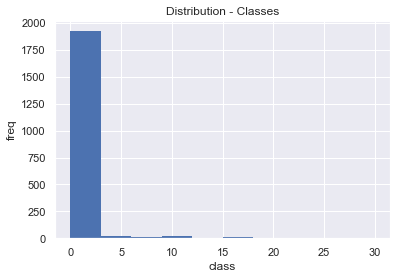

In [15]:
ax=y.hist()
ax.set_xlabel("class")
ax.set_ylabel("freq")
ax.set_title("Distribution - Classes")


In [16]:
sns.set(rc={
 'patch.force_edgecolor': True
})

In [17]:
np.unique(y)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 15, 17, 19, 22, 23,
       24, 28, 30])

In [18]:
X_train, X_test, y_train, y_test=train_test_split(X,y,test_size=0.3,random_state = 49)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1400, 2964), (600, 2964), (1400,), (600,))

In [19]:
np.unique(y_test)

array([ 0,  1,  2,  4,  5,  6,  7,  8,  9, 11, 17, 19, 22])

## Bayes naïf

In [20]:
NaiveBayes = naive_bayes.GaussianNB().fit(X_train, y_train)
y_pred_train=NaiveBayes.predict(X_train)
y_pred_test=NaiveBayes.predict(X_test)
y_pred_train.shape,y_pred_test.shape

((1400,), (600,))

In [21]:
np.unique(y_pred_train)

array([ 0,  1,  2,  3,  4,  6,  8,  9, 10, 11, 15, 17, 19, 22, 23, 24, 28,
       30])

Text(0.5, 0.98, 'Distribution des classes (y test) - Bayesien naïf')

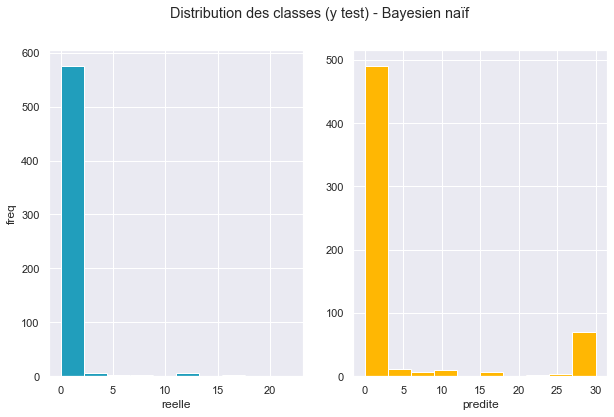

In [22]:
plt.figure(figsize=(10,6))
plt.subplot(1,2,1)
plt.hist(y_test,color="#219ebc")
plt.xlabel('reelle')
plt.ylabel('freq')


plt.subplot(1,2,2)
plt.hist(y_pred_test,color="#ffb703")
plt.xlabel('predite')

plt.suptitle("Distribution des classes (y test) - Bayesien naïf")

In [23]:
# scores exactitude, ari
accuracy = accuracy_score(y_test, y_pred_test) 
ari = adjusted_rand_score(y_test, y_pred_test)
dfScore=pd.DataFrame({'Metrique':['Accuracy','ARI'],'Score':[accuracy,ari]})
dfScore.T

,0,1
Metrique,Accuracy,ARI
Score,0.79,0.049581


In [24]:
np.unique(y_test), np.unique(y_pred_test)

(array([ 0,  1,  2,  4,  5,  6,  7,  8,  9, 11, 17, 19, 22]),
 array([ 0,  1,  2,  3,  4,  6,  8,  9, 11, 17, 22, 24, 28, 30]))

In [25]:
dfConfusion=confusionMatrixAcc(y_test, y_pred_test)
dfConfusion['Tag']=dfConfusion['Class'].map(map_classtag)
dfConfusion = dfConfusion[['Class','Tag', 'TP', 'FP', 'TN', 'TPR','FPR','Accuracy']] 
dfConfusion

,Class,Tag,TP,FP,TN,TPR,FPR,Accuracy
1,1,javascript,0,1,469,0.000000,0.002128,0.995754
10,22,visual,0,2,469,0.000000,0.004246,0.993644
2,2,android,0,3,469,0.000000,0.006356,0.991543
5,6,jquery,0,2,469,0.000000,0.004246,0.991543
7,9,html,0,4,469,0.000000,0.008457,0.989451
4,4,java,4,4,465,0.666667,0.008529,0.987368
6,8,sql,0,4,469,0.000000,0.008457,0.987368
9,17,server,1,6,468,0.333333,0.012658,0.983229
8,11,asp,0,6,469,0.000000,0.012632,0.975052
0,0,NaN,469,18,0,0.817073,1.000000,0.792230


## Random forest

In [26]:
rfc = RandomForestClassifier(random_state=43)

rfc.fit(X_train, y_train)

RandomForestClassifier(random_state=43)

In [27]:
y_pred_train=rfc.predict(X_train)
y_pred_test=rfc.predict(X_test)
np.unique(y_pred_train)

array([ 0,  1,  2,  3,  4,  6,  8,  9, 10, 11, 15, 17, 19, 22, 23, 24, 28,
       30])

Text(0.5, 0.98, 'Distribution des classes (y test) - Random Forest')

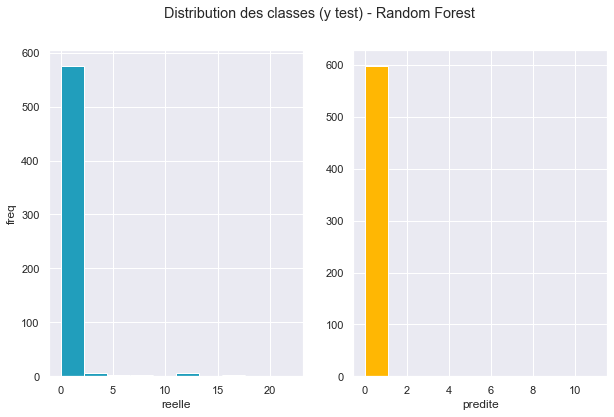

In [28]:
plt.figure(figsize=(10,6))
plt.subplot(1,2,1)
plt.hist(y_test,color="#219ebc")
plt.xlabel('reelle')
plt.ylabel('freq')


plt.subplot(1,2,2)
plt.hist(y_pred_test,color="#ffb703")
plt.xlabel('predite')

plt.suptitle("Distribution des classes (y test) - Random Forest")

In [29]:
# scores exactitude, ari
accuracy = accuracy_score(y_test, y_pred_test) 
ari = adjusted_rand_score(y_test, y_pred_test)
dfScore=pd.DataFrame({'Metrique':['Accuracy','ARI'],'Score':[accuracy,ari]})
dfScore.T

,0,1
Metrique,Accuracy,ARI
Score,0.958333,0.069158


In [30]:
y_test.shape,y_pred_test.shape

((600,), (600,))

In [31]:
np.unique(y_test), np.unique(y_pred_test)

(array([ 0,  1,  2,  4,  5,  6,  7,  8,  9, 11, 17, 19, 22]), array([ 0, 11]))

In [32]:
dfConfusion=confusionMatrixAcc(y_test, y_pred_test)
dfConfusion['Tag']=dfConfusion['Class'].map(map_classtag)
dfConfusion = dfConfusion[['Class','Tag', 'TP', 'FP', 'TN', 'TPR','FPR','Accuracy']] 
dfConfusion

,Class,Tag,TP,FP,TN,TPR,FPR,Accuracy
1,11,asp,1,0,573,0.166667,0.0,0.991364
0,0,NaN,574,25,0,1.000000,1.0,0.958264


## Regression logistique

In [33]:
lr = linear_model.LogisticRegression(multi_class='ovr', solver='liblinear')

In [34]:
lr.fit(X_train, y_train)

LogisticRegression(multi_class='ovr', solver='liblinear')

In [35]:
y_pred_train=lr.predict(X_train)
y_pred_test=lr.predict(X_test)
np.unique(y_pred_train)

array([0])

Text(0.5, 0.98, 'Distribution des classes (y test) - Regression logistique')

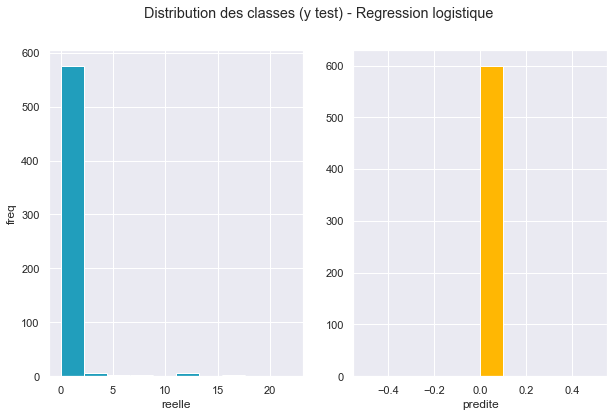

In [36]:
plt.figure(figsize=(10,6))
plt.subplot(1,2,1)
plt.hist(y_test,color="#219ebc")
plt.xlabel('reelle')
plt.ylabel('freq')


plt.subplot(1,2,2)
plt.hist(y_pred_test,color="#ffb703")
plt.xlabel('predite')

plt.suptitle("Distribution des classes (y test) - Regression logistique")

In [37]:
# scores exactitude, ari
accuracy = accuracy_score(y_test, y_pred_test) 
ari = adjusted_rand_score(y_test, y_pred_test)
dfScore=pd.DataFrame({'Metrique':['Accuracy','ARI'],'Score':[accuracy,ari]})
dfScore.T

,0,1
Metrique,Accuracy,ARI
Score,0.956667,0.0


In [38]:
dfConfusion=confusionMatrixAcc(y_test, y_pred_test)
dfConfusion['Tag']=dfConfusion['Class'].map(map_classtag)
dfConfusion = dfConfusion[['Class','Tag', 'TP', 'FP', 'TN', 'TPR','FPR','Accuracy']] 
dfConfusion

,Class,Tag,TP,FP,TN,TPR,FPR,Accuracy
0,0,NaN,574,26,0,1.0,1.0,0.956667


## XGBoost

In [39]:
model=XGBClassifier(eta=0.1,n_estimators=100,max_depth=4,subsample=1,colsample_bytree=0.8,objective='multi:softmax')
model.fit(X_train,y_train)

/Users/hui-guan/opt/miniconda3/envs/python3.8/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[22:08:35] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1634712680264/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8,
              enable_categorical=False, eta=0.1, gamma=0, gpu_id=-1,
              importance_type=None, interaction_constraints='',
              learning_rate=0.100000001, max_delta_step=0, max_depth=4,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=12, num_parallel_tree=1,
              objective='multi:softprob', predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [40]:
y_pred_train=model.predict(X_train)
y_pred_test=model.predict(X_test)
np.unique(y_pred_train)

array([ 0,  4,  6,  8,  9, 11, 17, 24, 28])

Text(0.5, 0.98, 'Distribution des classes (y test) - XGBoost')

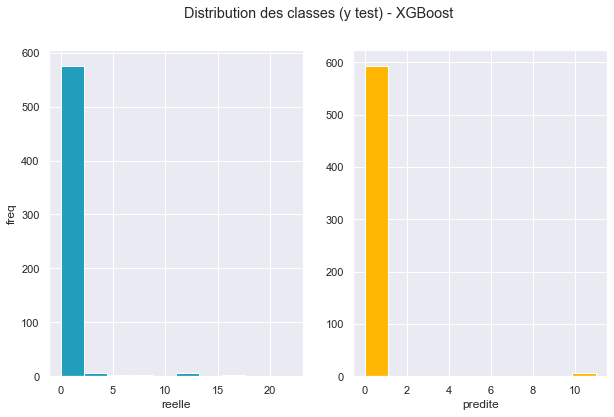

In [41]:
plt.figure(figsize=(10,6))
plt.subplot(1,2,1)
plt.hist(y_test,color="#219ebc")
plt.xlabel('reelle')
plt.ylabel('freq')


plt.subplot(1,2,2)
plt.hist(y_pred_test,color="#ffb703")
plt.xlabel('predite')

plt.suptitle("Distribution des classes (y test) - XGBoost")

In [42]:
# scores exactitude, ari
accuracy = accuracy_score(y_test, y_pred_test) 
ari = adjusted_rand_score(y_test, y_pred_test)
dfScore=pd.DataFrame({'Metrique':['Accuracy','ARI'],'Score':[accuracy,ari]})
dfScore.T

,0,1
Metrique,Accuracy,ARI
Score,0.963333,0.295387


In [43]:
dfConfusion=confusionMatrixAcc(y_test, y_pred_test)
dfConfusion['Tag']=dfConfusion['Class'].map(map_classtag)
dfConfusion = dfConfusion[['Class','Tag', 'TP', 'FP', 'TN', 'TPR','FPR','Accuracy']] 
dfConfusion

,Class,Tag,TP,FP,TN,TPR,FPR,Accuracy
1,11,asp,5,1,568,0.833333,0.001757,0.996522
0,0,NaN,573,21,0,0.998258,1.000000,0.963025


## Reseau de neurones

In [44]:
X.shape

(2000, 2964)

In [45]:
tf.config.run_functions_eagerly(True) #activation de l'execution en mode dynamique

# Parametres du reseau de neurones
EPOCHS = 60 # iterations
BATCH_SIZE = 8 #taille de l'echantillon par iteration
VERBOSE = 1
NB_CLASSES = 30   # nombre de neurones/classe en sortie
N_HIDDEN = 26 # nombre de neurones des couches cachees = nombre d'observations/(2*(nombre de neurones input + nombre de neurones output))
VALIDATION_SPLIT = 0.2 # pourcentage des donnees d'entrainement reservées pour la validation
DROPOUT = 0.3

INPUT_SHAPE = X_train.shape

In [46]:
INPUT_SHAPE[1]

2964

In [47]:
# Creation du modele
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Dense(INPUT_SHAPE[1],
    input_dim=INPUT_SHAPE[1],
    name='input_layer', 
    activation='relu'))
model.add(tf.keras.layers.Dropout(DROPOUT))
model.add(tf.keras.layers.Dense(N_HIDDEN,
    name='hidden_layer_1',
    activation='relu'))
model.add(tf.keras.layers.Dropout(DROPOUT))
model.add(tf.keras.layers.Dense(N_HIDDEN,
    name='hidden_layer_2',
    activation='relu'))
model.add(tf.keras.layers.Dropout(DROPOUT))
model.add(tf.keras.layers.Dense(NB_CLASSES+1,
    name='output_layer',
    activation='softmax'))

2021-12-04 22:08:53.670535: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [48]:
# Caracteristique/description du modele
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (Dense)          (None, 2964)              8788260   
_________________________________________________________________
dropout (Dropout)            (None, 2964)              0         
_________________________________________________________________
hidden_layer_1 (Dense)       (None, 26)                77090     
_________________________________________________________________
dropout_1 (Dropout)          (None, 26)                0         
_________________________________________________________________
hidden_layer_2 (Dense)       (None, 26)                702       
_________________________________________________________________
dropout_2 (Dropout)          (None, 26)                0         
_________________________________________________________________
output_layer (Dense)         (None, 31)                8

In [49]:
# Compilation
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy', # methode de calcul de cout
              metrics=['accuracy']) # methode d'evaluation

In [50]:
%%time
callbacks = [
  #  Objet History pour monitorer les iterations
  tf.keras.callbacks.History(),
  # Logs pour TensorBoard dans le repertoire './logs' 
  #tf.keras.callbacks.TensorBoard(log_dir='./logs') # activation des logs pour TensorBoard
]

history = model.fit(X, y, batch_size=BATCH_SIZE, epochs=EPOCHS , verbose = VERBOSE, validation_split = VALIDATION_SPLIT, callbacks = callbacks)

/Users/hui-guan/opt/miniconda3/envs/python3.8/lib/python3.8/site-packages/tensorflow/python/data/ops/dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(
2021-12-04 22:08:53.843906: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)


Epoch 1/60
200/200 [==============================] - 10s 50ms/step - loss: 1.2757 - accuracy: 0.9181 - val_loss: 0.4792 - val_accuracy: 0.9450
Epoch 2/60
200/200 [==============================] - 8s 40ms/step - loss: 0.2803 - accuracy: 0.9613 - val_loss: 0.4504 - val_accuracy: 0.9450
Epoch 3/60
200/200 [==============================] - 9s 44ms/step - loss: 0.1737 - accuracy: 0.9633 - val_loss: 0.5432 - val_accuracy: 0.9450
Epoch 4/60
200/200 [==============================] - 8s 39ms/step - loss: 0.1687 - accuracy: 0.9610 - val_loss: 0.7180 - val_accuracy: 0.9450
Epoch 5/60
200/200 [==============================] - 8s 38ms/step - loss: 0.1492 - accuracy: 0.9597 - val_loss: 0.6485 - val_accuracy: 0.9450
Epoch 6/60
200/200 [==============================] - 8s 40ms/step - loss: 0.1127 - accuracy: 0.9662 - val_loss: 0.7226 - val_accuracy: 0.9425
Epoch 7/60
200/200 [==============================] - 8s 38ms/step - loss: 0.1387 - accuracy: 0.9593 - val_loss: 0.9366 - val_accuracy: 0.942

Epoch 58/60
200/200 [==============================] - 8s 38ms/step - loss: 0.0367 - accuracy: 0.9878 - val_loss: 5.7369 - val_accuracy: 0.9350
Epoch 59/60
200/200 [==============================] - 8s 38ms/step - loss: 0.0496 - accuracy: 0.9887 - val_loss: 5.5808 - val_accuracy: 0.9350
Epoch 60/60
200/200 [==============================] - 8s 38ms/step - loss: 0.0102 - accuracy: 0.9967 - val_loss: 5.7797 - val_accuracy: 0.9375
CPU times: user 45min 9s, sys: 1min 14s, total: 46min 24s
Wall time: 7min 44s


In [51]:
model.save('rn2')
#model = tf.keras.models.load_model("rn2")

2021-12-04 22:16:39.057087: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: rn2/assets


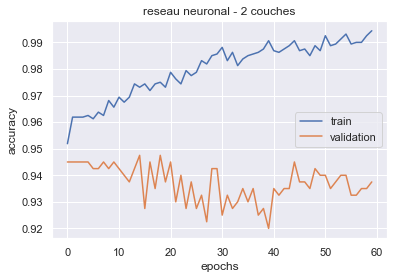

In [52]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('reseau neuronal - 2 couches')
plt.ylabel('accuracy')
plt.xlabel('epochs')
plt.legend(['train' , 'validation'] , loc = 'right')
plt.show()

La courbe de validation reste autour de 70% de taux d'exactitude, alors que celle d'entrainement tend vers 95% au bout de 50 itérations.
On constate donc du surentrainement.

In [53]:
X_test.shape

(600, 2964)

In [54]:
y_pred_test=np.squeeze(model.predict_classes(X_test)) #helps to get rid of useless one dimension arrays  and predict classes directly instead of probability

/Users/hui-guan/opt/miniconda3/envs/python3.8/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '
/Users/hui-guan/opt/miniconda3/envs/python3.8/lib/python3.8/site-packages/tensorflow/python/data/ops/dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


In [55]:
np.unique(y_pred_test),y_pred_test.shape

(array([ 0,  2,  3,  4,  6,  8, 11, 17, 24]), (600,))

Text(0.5, 0.98, 'Distribution des classes (y test) - Réseau neuronal')

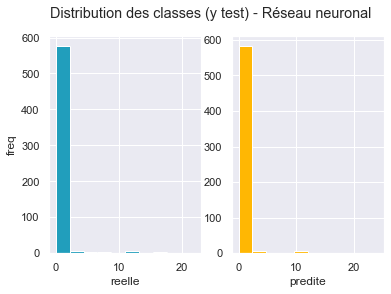

In [56]:
plt.figure(figsize=(6,4))
plt.subplot(1,2,1)
plt.hist(y_test,color="#219ebc")
plt.xlabel('reelle')
plt.ylabel('freq')


plt.subplot(1,2,2)
plt.hist(y_pred_test,color="#ffb703")
plt.xlabel('predite')

plt.suptitle("Distribution des classes (y test) - Réseau neuronal")

In [57]:
# scores exactitude, ari
accuracy = accuracy_score(y_test, y_pred_test) 
ari = adjusted_rand_score(y_test, y_pred_test)
dfScore=pd.DataFrame({'Metrique':['Accuracy','ARI'],'Score':[accuracy,ari]})
dfScore.T

,0,1
Metrique,Accuracy,ARI
Score,0.983333,0.834407


In [58]:
dfConfusion=confusionMatrixAcc(y_test, y_pred_test)
dfConfusion['Tag']=dfConfusion['Class'].map(map_classtag)
dfConfusion = dfConfusion[['Class','Tag', 'TP', 'FP', 'TN', 'TPR','FPR','Accuracy']] 
dfConfusion

,Class,Tag,TP,FP,TN,TPR,FPR,Accuracy
1,2,android,1,0,577,1.000000,0.000000,1.000000
4,6,jquery,2,0,576,1.000000,0.000000,1.000000
5,8,sql,2,0,576,1.000000,0.000000,1.000000
7,17,server,2,0,576,0.666667,0.000000,0.998273
3,4,java,4,0,574,0.666667,0.000000,0.996552
6,11,asp,5,1,573,0.833333,0.001742,0.996552
0,0,NaN,574,7,4,1.000000,0.636364,0.988034
2,3,php,0,0,0,0.000000,0.000000,0.000000
8,24,xml,0,0,0,0.000000,0.000000,0.000000


## LDA

In [59]:
# instanciation du modele
model=LatentDirichletAllocation(n_components=30)

X_topics = model.fit_transform(X)

# distribution des themes
topic_words=model.components_

# termes des thematiques
words = dfTFIDFCommon.columns

for index, component in enumerate(topic_words):
    zipped = zip(words, component)
    top_terms_key=sorted(zipped, key = lambda t: t[1], reverse=True)[:7]
    topics=list(dict(top_terms_key).keys())
    print("Topic "+str(index)+": ",topics)

Topic 0:  ['get specific', 'instance method', 'dimensional array', 'get start', 'gmail chat', 'argument fopen', 'use argument']
Topic 1:  ['query return', 'def foo', 'web page', 'ant build', 'change exponent', 'large file', 'android text']
Topic 2:  ['object create', 'type error', 'property viewmodel', 'type string', 'throw exception', 'file struct', 'wordpress joomla']
Topic 3:  ['value array', 'console log', 'find large', 'code use', 'imageview android', 'try use', 'business object']
Topic 4:  ['get result', 'way check', 'virtual function', 'pythonic way', 'window form', 'laravel clause', 'one problem']
Topic 5:  ['vb net', 'remove string', 'undefined reference', 'java ee', 'python code', 'apply node', 'server hostname']
Topic 6:  ['web service', 'method use', 'asp net', 'pitfall avoid', 'name use', 'poco entity', 'serialize poco']
Topic 7:  ['extension method', 'window api', 'infinite loop', 'arithmetic operation', 'android app', 'bluetooth message', 'send bluetooth']
Topic 8:  ['ev

In [60]:
# assign topic to documents
doc_topic=model.transform(X_train)

for n in range(doc_topic.shape[0]):
    # maximum index value
    topic_doc=doc_topic[n].argmax()
    
    print(f"Document {n+1} -- Topic: {topic_doc}")

Document 1 -- Topic: 26
Document 2 -- Topic: 6
Document 3 -- Topic: 24
Document 4 -- Topic: 28
Document 5 -- Topic: 14
Document 6 -- Topic: 22
Document 7 -- Topic: 15
Document 8 -- Topic: 20
Document 9 -- Topic: 27
Document 10 -- Topic: 14
Document 11 -- Topic: 9
Document 12 -- Topic: 26
Document 13 -- Topic: 20
Document 14 -- Topic: 4
Document 15 -- Topic: 4
Document 16 -- Topic: 13
Document 17 -- Topic: 14
Document 18 -- Topic: 19
Document 19 -- Topic: 26
Document 20 -- Topic: 10
Document 21 -- Topic: 29
Document 22 -- Topic: 13
Document 23 -- Topic: 2
Document 24 -- Topic: 6
Document 25 -- Topic: 15
Document 26 -- Topic: 13
Document 27 -- Topic: 2
Document 28 -- Topic: 0
Document 29 -- Topic: 29
Document 30 -- Topic: 27
Document 31 -- Topic: 16
Document 32 -- Topic: 0
Document 33 -- Topic: 16
Document 34 -- Topic: 9
Document 35 -- Topic: 22
Document 36 -- Topic: 24
Document 37 -- Topic: 3
Document 38 -- Topic: 22
Document 39 -- Topic: 8
Document 40 -- Topic: 0
Document 41 -- Topic: 

Document 1287 -- Topic: 4
Document 1288 -- Topic: 3
Document 1289 -- Topic: 25
Document 1290 -- Topic: 13
Document 1291 -- Topic: 0
Document 1292 -- Topic: 13
Document 1293 -- Topic: 13
Document 1294 -- Topic: 10
Document 1295 -- Topic: 27
Document 1296 -- Topic: 27
Document 1297 -- Topic: 1
Document 1298 -- Topic: 0
Document 1299 -- Topic: 26
Document 1300 -- Topic: 20
Document 1301 -- Topic: 16
Document 1302 -- Topic: 16
Document 1303 -- Topic: 0
Document 1304 -- Topic: 15
Document 1305 -- Topic: 14
Document 1306 -- Topic: 29
Document 1307 -- Topic: 8
Document 1308 -- Topic: 19
Document 1309 -- Topic: 11
Document 1310 -- Topic: 4
Document 1311 -- Topic: 26
Document 1312 -- Topic: 21
Document 1313 -- Topic: 0
Document 1314 -- Topic: 11
Document 1315 -- Topic: 13
Document 1316 -- Topic: 11
Document 1317 -- Topic: 26
Document 1318 -- Topic: 3
Document 1319 -- Topic: 14
Document 1320 -- Topic: 21
Document 1321 -- Topic: 23
Document 1322 -- Topic: 7
Document 1323 -- Topic: 19
Document 132